# Title

In [1]:
import numpy as np
import scipy.sparse as sps
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import time


def guided_modes_1DTE(prm, k0, h):
    """Computes the effective permittivity of a TE polarized guided eigenmode.
    All dimensions are in µm.
    Note that modes are filtered to match the requirement that
    their effective permittivity is larger than the substrate (cladding).
    
    Parameters
    ----------
    prm : 1d-array
        Dielectric permittivity in the x-direction
    k0 : float
        Free space wavenumber
    h : float
        Spatial discretization
    
    Returns
    -------
    eff_eps : 1d-array
        Effective permittivity vector of calculated modes
    guided : 2d-array
        Field distributions of the guided eigenmodes
    """
    arr_diag = -2/(h**2) + k0**2 * prm
    arr_adj = 1/(h**2) * np.ones_like(prm[:-1])
    M = (np.diag(arr_diag) + np.diag(arr_adj, -1) + np.diag(arr_adj, 1)) * 1/(k0**2)
    e_eff, guided = np.linalg.eig(M)
    e_eff = np.real(e_eff)
    # Filter modes to keep only those with effective permittivity larger than substrate
    mask = e_eff > e_substrate
    guided = guided[:, mask]
    #guided = np.abs(np.real(guided))  # Ensure field distributions are non-negative
    e_eff = e_eff[mask]
    return e_eff, guided 


Plotting:
The plot displays both the error $\Delta\epsilon$ between the calculated effective permittivity and the benchmark value of the fundamental mode, as well as the computation time required for each simulation, as functions of the spatial resolution. As the spatial resolution increases (i.e., as the grid becomes finer), the computation time rises nearly linearly on a logarithmic scale, reflecting the greater computational effort needed for finer discretization. Simultaneously, the error $\Delta\epsilon$ decreases rapidly and approaches zero, indicating convergence of the numerical solution toward the benchmark value. This demonstrates the trade-off between computational cost and numerical accuracy when choosing the spatial resolution.

Since the exact or analytical solutions of the differential equation are not known, we must define a measure for the accuracy of our computed numerical solution. To do this, we calculate a highly accurate reference solution using a very fine spatial discretization (i.e., a large value for the number_points variable). The effective permittivity $\epsilon_{eff}$ of the fundamental ($0^{th}$-order) mode from this high-resolution calculation is taken as the benchmark or reference value. By comparing the computed $\epsilon_{eff}$ for different, coarser spatial resolutions to this reference, we can quantitatively assess the convergence and accuracy of our numerical method. Furthermore, we measure the computation time required for each numerical solution. This allows us to identify an optimal spatial resolution that achieves sufficient accuracy without unnecessary expenditure of computational time and resources.

In [2]:
#1D Example Parameters --> very high resolution for reference
grid_size     = 120
number_points = 6000
h = grid_size / (number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0
xx            = np.linspace( -grid_size/2, grid_size/2, number_points)
prm           = e_substrate + delta_e * np.exp(-(xx/w)**2)

# Calculate the effective permittivity for the high-resolution case
e_eff, guided = guided_modes_1DTE(prm, k0, h)
e_eff_ref = e_eff[0]


# Performance Analysis
number_points_arr = np.logspace(1,3.5, num=21, dtype=int) #define the number points/ spatial resolutions to test
time_results = [] # List to store computation times
e_eff_results = [] # List to store effective permittivity results
spatial_resolutions = [] # List to store spatial resolutions
for num in number_points_arr:
    # For each number of points, compute the effective permittivity
    # define the parameters that depend on the number of points
    h = grid_size / (num - 1)
    spatial_resolutions.append(h) #store the spatial resolution
    xx = np.linspace( -grid_size/2, grid_size/2, num)
    prm = e_substrate + delta_e * np.exp(-(xx/w)**2)
    start_time = time.time() # start the timer
    e_eff, guided = guided_modes_1DTE(prm, k0, h) # calculate the effective permittivity/ guided modes
    end_time = time.time() # end the timer
    time_results.append(end_time - start_time) #store the time taken for this calculation
    e_eff_results.append(e_eff[0]) #store the effective permittivity of the first mode

error = np.abs(e_eff_results - e_eff_ref) # Calculate the error compared to the benchmark value


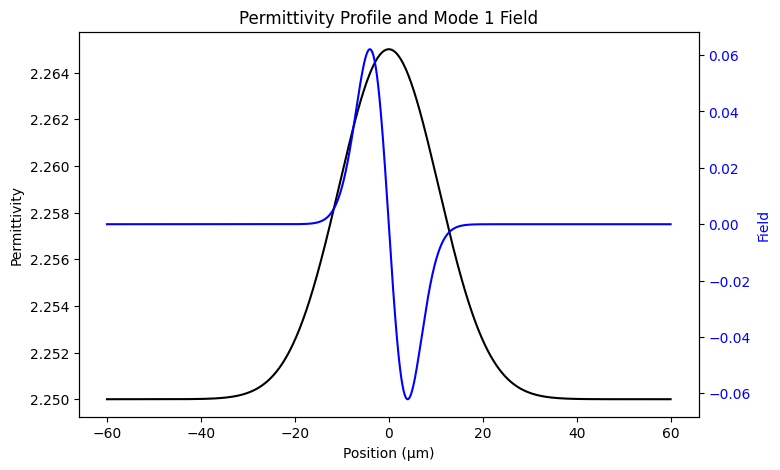

In [3]:
# Plotting the results for the 1D example
plt.figure(figsize=(8, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()

# First y-axis: Permittivity Profile
ax1.plot(xx, prm, label='Permittivity Profile', color='black')
ax1.set_ylabel('Permittivity', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlabel('Position (µm)')

# Second y-axis: Mode 1
ax2.plot(xx, np.real(guided[:, 1]), label='Mode 1', color='blue')
#ax2.plot(xx, np.real(guided[:, 1]), label='Mode 2', color='blue')
ax2.set_ylabel('Field', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Permittivity Profile and Mode 1 Field')
plt.show()

Plotting:
The plot displays both the error $\Delta\epsilon$ between the calculated effective permittivity and the benchmark value of the fundamental mode, as well as the computation time required for each simulation, as functions of the spatial resolution. As the spatial resolution increases (i.e., as the grid becomes finer), the computation time rises nearly linearly on a logarithmic scale, reflecting the greater computational effort needed for finer discretization. Simultaneously, the error $\Delta\epsilon$ decreases rapidly and approaches zero, indicating convergence of the numerical solution toward the benchmark value. This demonstrates the trade-off between computational cost and numerical accuracy when choosing the spatial resolution.

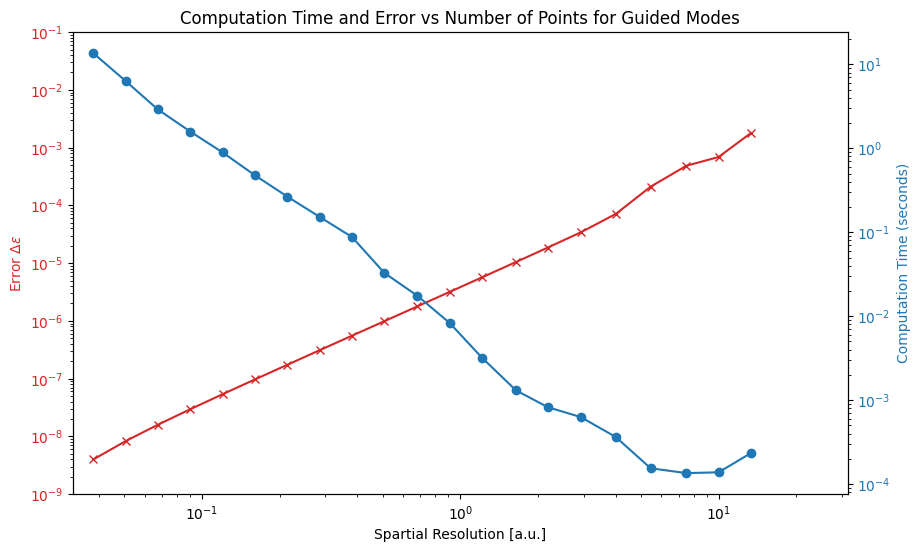

In [ ]:
# Plotting computation time and error on the same plot with two y-axes
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot error (left y-axis)
ax1.plot(spatial_resolutions, error, marker='x', color='tab:red', label='Effective Permittivity')
ax1.scatter(8000, 0, color='black', label='Reference Value', zorder=5, marker="x")
ax1.axhline(0, color='black', linestyle='--')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([10**(-1.5), 10**(1.5)])  # Set x-axis limits for better visibility
ax1.set_ylim([1e-9, 1e-1])  # Set y-axis limits for better visibility
ax1.set_xlabel('Spartial Resolution [a.u.]')
ax1.set_ylabel(r'Error $\Delta\epsilon$', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
#ax1.legend(loc='lower right')

# Plot computation time (right y-axis)
ax2.plot(spatial_resolutions, time_results, marker='o', color='tab:blue', label='Computation Time')
ax2.set_yscale('log')
ax2.set_ylabel('Computation Time (seconds)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
#ax2.legend(loc='lower right')

plt.title('Computation Time and Error vs Number of Points for Guided Modes')
plt.show()

In [16]:
def guided_modes_2D(prm, k0, h, numb):
    """Computes the effective permittivity of a quasi-TE polarized guided 
    eigenmode. All dimensions are in µm.
    
    Parameters
    ----------
    prm  : 2d-array
        Dielectric permittivity in the xy-plane
    k0 : float
        Free space wavenumber
    h : float
        Spatial discretization
    numb : int
        Number of eigenmodes to be calculated
    
    Returns
    -------
    eff_eps : 1d-array
        Effective permittivity vector of calculated eigenmodes
    guided : 3d-array
        Field distributions of the guided eigenmodes
    """
    M = sps.diags(-4/(h**2) + k0**2 * prm.flatten()) #main diagonal
    #adjecent diagonals for differentiation in x-direction
    M += sps.diags(1/(h**2) * np.ones_like(prm.flatten()[:-1]), -1) 
    M += sps.diags(1/(h**2) * np.ones_like(prm.flatten()[:-1]), 1)
    #adjecent diagonals for differentiation in y-direction
    M += sps.diags(1/(h**2) * np.ones_like(prm.flatten()[:-len(xx)]), -len(xx))
    M += sps.diags(1/(h**2) * np.ones_like(prm.flatten()[:-len(xx)]), len(xx))
    M *= 1/(k0**2) #multiply with pre-factor to get the correct units

    # Calculate eigenvalues and eigenvectors
    e_eff, guided = sps.linalg.eigs(M, k=numb, which='LR')

    # Filter modes to keep only those with effective permittivity larger than substrate
    #filter e_substrate < e_eff < e_substrate + delta_e

    mask = (e_eff > e_substrate) & (e_eff < e_substrate + delta_e)
    guided = guided[:, mask]
    #guided = np.abs(np.real(guided))  # Ensure field distributions are non-negative
    e_eff = e_eff[mask]
    # Reshape guided modes to 2D
    guided = guided.reshape(len(yy), len(xx), -1)
    return e_eff, guided

#2D Example Parameters
grid_size     = 120
number_points = 300
h             = grid_size/(number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0
xx            = np.linspace(-grid_size/2-h,grid_size/2+h,number_points+2)
yy            = np.linspace(-grid_size/2,grid_size/2,number_points)
XX,YY         = np.meshgrid(xx,yy)
prm           = e_substrate + delta_e * np.exp(-(XX**2+YY**2)/w**2)
print("Shape of permittivity profile:", prm.shape)


Shape of permittivity profile: (300, 302)


Plot the permittivity profile

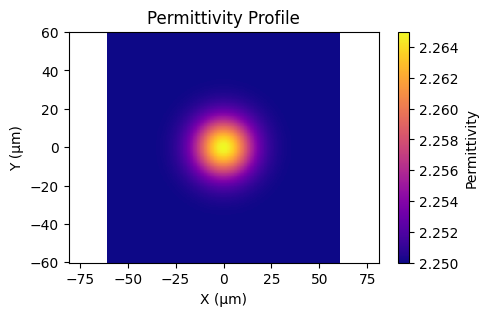

In [143]:
plt.figure(figsize=(5, 3))
plt.pcolormesh(XX, YY, prm, shading='auto', cmap='plasma')
plt.colorbar(label='Permittivity')
plt.title('Permittivity Profile')
plt.xlabel('X (µm)')
plt.ylabel('Y (µm)')
plt.axis('equal')
plt.show()

Calculate the eigenvalues and eigenfunctions

In [14]:
e_eff, guided = guided_modes_2D(prm, k0, h, numb=2)

Plot of the first eigenfunction

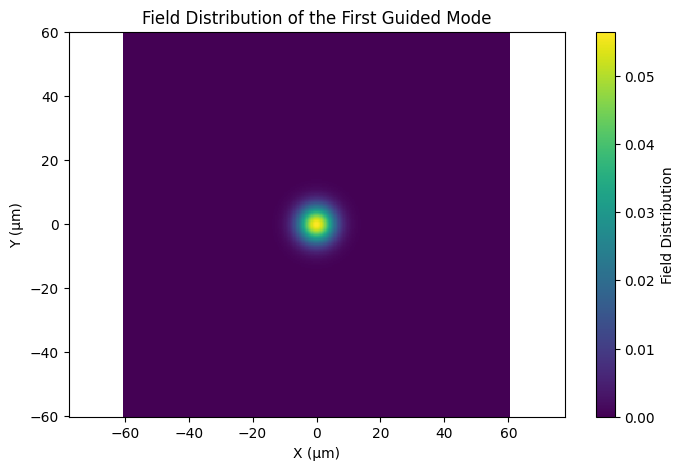

In [15]:
# Plotting the first guided mode
plt.figure(figsize=(8, 5))
plt.pcolormesh(XX, YY, np.real(guided[:, :,0]), shading='auto', cmap='viridis')
plt.colorbar(label='Field Distribution')
plt.title('Field Distribution of the First Guided Mode')
plt.xlabel('X (µm)')
plt.ylabel('Y (µm)')
plt.axis('equal')
plt.show()

To check the convergence of the numerical solution, we used the same approach as in the first task by investigating the effective permittivity for the $0^{\text{th}}$-order mode at different spatial resolutions. By focusing only on the $0^{\text{th}}$-order mode, we only need to calculate the first eigenvalue. Since the calculation for the two-dimensional system is more demanding, the benchmark value is determined using a lower spatial resolution (1500 points) compared to the 1D problem. As before, we also measured the computation time required for each solution.

In [185]:
#calculation of a benchmark value --> using a high resolution
grid_size     = 120
number_points = 1500
h             = grid_size/(number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0
xx            = np.linspace(-grid_size/2-h,grid_size/2+h,number_points+2)
yy            = np.linspace(-grid_size/2,grid_size/2,number_points)
XX,YY         = np.meshgrid(xx,yy)
prm           = e_substrate + delta_e * np.exp(-(XX**2+YY**2)/w**2)


e_eff_ref_2d, guided_ref = guided_modes_2D(prm, k0, h, numb=1)


In [186]:
#computation time and error for 2D example
number_points_arr = np.logspace(0.5,3, num=21, dtype=int)
time_results_2d = []
e_eff_results_2d = []
spatial_resolutions_2d = []
for num in number_points_arr:
    h = grid_size / (num - 1)
    spatial_resolutions_2d.append(h)
    xx            = np.linspace(-grid_size/2-h,grid_size/2+h,num+2)
    yy            = np.linspace(-grid_size/2,grid_size/2,num)
    XX,YY         = np.meshgrid(xx,yy)
    prm           = e_substrate + delta_e * np.exp(-(XX**2+YY**2)/w**2)
    start_time = time.time()
    e_eff, guided = guided_modes_2D(prm, k0, h, numb=1)
    if e_eff.size == 0:
        e_eff = np.array([np.nan])  # Handle cases where no modes are found
    else:
        e_eff = np.real(e_eff)
    end_time = time.time()
    time_results_2d.append(end_time - start_time)
    e_eff_results_2d.append(e_eff[0])

error_2d = np.abs(e_eff_results_2d - e_eff_ref_2d)

Plotting:
We can again plot the deviation from the benchmark value and the computation time for different spatial resolutions, obtaining similar results as in the 1D case. Initially, there is a pronounced (though nearly linear) increase in computation time as the spatial resolution becomes finer. At the same time, for higher resolutions, the effective permittivity converges to the benchmark value, and the error approaches zero.

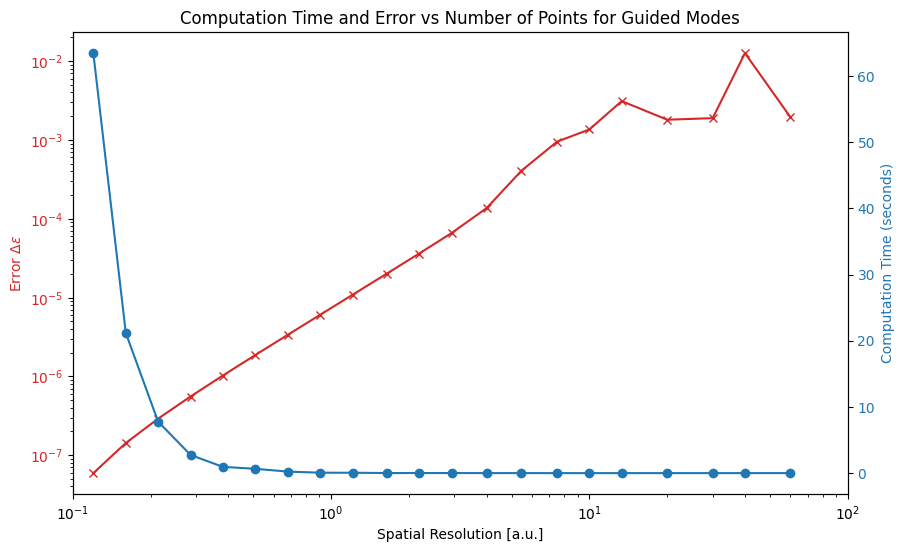

In [188]:
# Plotting computation time and error on the same plot with two y-axes
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot error (left y-axis)
ax1.plot(spatial_resolutions_2d, error_2d, marker='x', color='tab:red', label='Effective Permittivity')
ax1.scatter(8000, 0, color='black', label='Reference Value', zorder=5, marker="x")
ax1.axhline(0, color='black', linestyle='--')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([10**(-1), 10**(2)])  # Set x-axis limits for better visibility
ax1.set_xlabel('Spatial Resolution [a.u.]')
ax1.set_ylabel(r'Error $\Delta\epsilon$', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
#ax1.legend(loc='lower right')

# Plot computation time (right y-axis)
ax2.plot(spatial_resolutions_2d, time_results_2d, marker='o', color='tab:blue', label='Computation Time')
#ax2.set_yscale('log')
ax2.set_ylabel('Computation Time (seconds)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
#ax2.legend(loc='lower right')

plt.title('Computation Time and Error vs Number of Points for Guided Modes')
plt.show()